# ConcatBERT Training
### Classifying movie genres from plot and movie poster

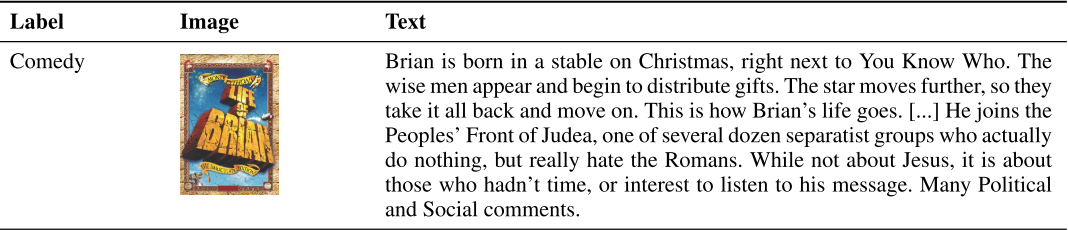

Gated Multimodal Units for Information Fusion (Arevalo et al.)

In [ ]:
!pip install transformers

In [2]:
import json
import numpy as np
import os
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import functools
from collections import Counter
from argparse import Namespace
from transformers import BertTokenizer, BertModel
from tqdm.notebook import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
!wget http://lisi1.unal.edu.co/mmimdb/mmimdb.tar.gz

In [ ]:
!tar -zxf mmimdb.tar.gz

Vocabulary

In [ ]:
class Vocab(object):
    def __init__(self, emptyInit=False):
        if emptyInit:
            self.stoi, self.itos, self.vocab_sz = {}, [], 0
        else:
            self.stoi = {
                w: i
                for i, w in enumerate(["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"])
            }
            self.itos = [w for w in self.stoi]
            self.vocab_sz = len(self.itos)

    def add(self, words):
        cnt = len(self.itos)
        for w in words:
            if w in self.stoi:
                continue
            self.stoi[w] = cnt
            self.itos.append(w)
            cnt += 1
        self.vocab_sz = len(self.itos)

In [ ]:
args = Namespace()
args.savedir = os.path.join('model_save', 'concat_bert')
os.makedirs(args.savedir, exist_ok=True)
args.data_path = "mmimdb"

Load dataset partitions, set of labels (Movie genres) and frequencies


In [ ]:
label_freqs = Counter()
data_labels = [json.loads(line)["label"] for line in open(os.path.join(args.data_path, "train.jsonl"))]

if type(data_labels[0]) == list:
    for label_row in data_labels:
        label_freqs.update(label_row)
else:
    label_freqs.update(data_labels)

args.labels = list(label_freqs.keys())
args.label_freqs = label_freqs

In [ ]:
args.labels

['Drama',
 'Film-Noir',
 'Mystery',
 'Thriller',
 'Adventure',
 'Crime',
 'Horror',
 'Romance',
 'Sport',
 'Fantasy',
 'Biography',
 'Action',
 'Music',
 'War',
 'Documentary',
 'Short',
 'Animation',
 'Comedy',
 'Family',
 'Musical',
 'Sci-Fi',
 'Western',
 'History']

Create vocabulary

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
vocab = Vocab()
vocab.stoi = tokenizer.vocab
vocab.itos = tokenizer.ids_to_tokens
vocab.vocab_sz = len(vocab.itos)
args.vocab = vocab
args.vocab_sz = vocab.vocab_sz
args.n_classes = len(args.labels)
tokenizer = tokenizer.tokenize

In [ ]:
args.n_classes

23

Dataset

In [ ]:
class JsonlDataset(Dataset):
    def __init__(self, data_path, tokenizer, transforms, vocab, args):
        self.data = [json.loads(l) for l in open(data_path)]
        self.data_dir = os.path.dirname(data_path)
        self.tokenizer = tokenizer
        self.args = args
        self.vocab = vocab
        self.n_classes = len(args.labels)
        self.text_start_token = ["[CLS]"]

        self.max_seq_len = args.max_seq_len
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sentence = (
            self.text_start_token
            + self.tokenizer(self.data[index]["text"])[:(self.args.max_seq_len - 1)]
        )
        segment = torch.zeros(len(sentence))

        sentence = torch.LongTensor(
            [
                self.vocab.stoi[w] if w in self.vocab.stoi else self.vocab.stoi["[UNK]"]
                for w in sentence
            ]
        )

        label = torch.zeros(self.n_classes)
        label[
            [self.args.labels.index(tgt) for tgt in self.data[index]["label"]]
        ] = 1

        if self.data[index]["img"]:
            image = Image.open(
                os.path.join(self.data_dir, self.data[index]["img"])
            ).convert("RGB")
            
        image = self.transforms(image)

        return sentence, segment, image, label

Collate function to process batch

In [ ]:
def collate_fn(batch, args):
    lens = [len(row[0]) for row in batch]
    bsz, max_seq_len = len(batch), max(lens)

    mask_tensor = torch.zeros(bsz, max_seq_len).long()
    text_tensor = torch.zeros(bsz, max_seq_len).long()
    segment_tensor = torch.zeros(bsz, max_seq_len).long()

    img_tensor = torch.stack([row[2] for row in batch])

    tgt_tensor = torch.stack([row[3] for row in batch])

    for i_batch, (input_row, length) in enumerate(zip(batch, lens)):
        tokens, segment = input_row[:2]
        text_tensor[i_batch, :length] = tokens
        segment_tensor[i_batch, :length] = segment
        mask_tensor[i_batch, :length] = 1

    return text_tensor, segment_tensor, mask_tensor, img_tensor, tgt_tensor

Configure Dataset parameters

In [ ]:
args.max_seq_len = 512
args.batch_sz = 4
args.n_workers = 12

Create DataLoaders

In [ ]:
model_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.46777044, 0.44531429, 0.40661017],
            std=[0.12221994, 0.12145835, 0.14380469],
        ),
    ]
)

train = JsonlDataset(
    os.path.join(args.data_path, "train.jsonl"),
    tokenizer,
    model_transforms,
    vocab,
    args,
)

args.train_data_len = len(train)

dev = JsonlDataset(
    os.path.join(args.data_path, "dev.jsonl"),
    tokenizer,
    model_transforms,
    vocab,
    args,
)

collate = functools.partial(collate_fn, args=args)

train_loader = DataLoader(
    train,
    batch_size=args.batch_sz,
    shuffle=True,
    num_workers=args.n_workers,
    collate_fn=collate,
    drop_last=True,
)

val_loader = DataLoader(
    dev,
    batch_size=args.batch_sz,
    shuffle=False,
    num_workers=args.n_workers,
    collate_fn=collate,
)

test_set = JsonlDataset(
    os.path.join(args.data_path, "test.jsonl"),
    tokenizer,
    model_transforms,
    vocab,
    args,
)

test_loader = DataLoader(
    test_set,
    batch_size=args.batch_sz,
    shuffle=False,
    num_workers=args.n_workers,
    collate_fn=collate,
)

Define model

In [ ]:
class BertEncoder(nn.Module):
    def __init__(self, args):
        super(BertEncoder, self).__init__()
        self.args = args
        self.bert = BertModel.from_pretrained("bert-base-uncased")

    def forward(self, txt, mask, segment):
        _, out = self.bert(
            txt,
            token_type_ids=segment,
            attention_mask=mask,
            output_hidden_states=False,
        )
        return out

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self, args):
        super(ImageEncoder, self).__init__()
        self.args = args
        model = torchvision.models.resnet152(pretrained=True)
        modules = list(model.children())[:-2]
        self.model = nn.Sequential(*modules)

        pool_func = (
            nn.AdaptiveAvgPool2d
            if args.img_embed_pool_type == "avg"
            else nn.AdaptiveMaxPool2d
        )

        if args.num_image_embeds in [1, 2, 3, 5, 7]:
            self.pool = pool_func((args.num_image_embeds, 1))
        elif args.num_image_embeds == 4:
            self.pool = pool_func((2, 2))
        elif args.num_image_embeds == 6:
            self.pool = pool_func((3, 2))
        elif args.num_image_embeds == 8:
            self.pool = pool_func((4, 2))
        elif args.num_image_embeds == 9:
            self.pool = pool_func((3, 3))

    def forward(self, x):
        # Bx3x224x224 -> Bx2048x7x7 -> Bx2048xN -> BxNx2048
        out = self.pool(self.model(x))
        out = torch.flatten(out, start_dim=2)
        out = out.transpose(1, 2).contiguous()
        return out  # BxNx2048

In [ ]:
class MultimodalConcatBertClf(nn.Module):
    def __init__(self, args):
        super(MultimodalConcatBertClf, self).__init__()
        self.args = args
        self.txtenc = BertEncoder(args)
        self.imgenc = ImageEncoder(args)

        last_size = args.hidden_sz + (args.img_hidden_sz * args.num_image_embeds)
        self.clf = nn.ModuleList()

        self.clf.append(nn.Linear(last_size, args.n_classes))

    def forward(self, txt, mask, segment, img):
        txt = self.txtenc(txt, mask, segment)
        img = self.imgenc(img)
        img = torch.flatten(img, start_dim=1)
        out = torch.cat([txt, img], -1)
        for layer in self.clf:
            out = layer(out)
        return out

Define model hyperparameters and instantiate

In [ ]:
args.img_embed_pool_type = "avg"
args.num_image_embeds = 1
args.hidden_sz = 768
args.img_hidden_sz = 2048

In [ ]:
model = MultimodalConcatBertClf(args)

Create loss criterion

In [ ]:
freqs = [args.label_freqs[l] for l in args.labels]
label_weights = (torch.FloatTensor(freqs) / args.train_data_len) ** -1
criterion = nn.BCEWithLogitsLoss(pos_weight=label_weights.cuda())

Create optimizer

In [ ]:
args.lr = 1e-5
optimizer = optim.AdamW(model.parameters(), lr=args.lr)

Create scheduler

In [ ]:
args.lr_patience = 2
args.lr_factor = 0.5
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "max", patience=args.lr_patience, verbose=True, factor=args.lr_factor
    )

Setup training

In [ ]:
model.cuda();
torch.save(args, os.path.join(args.savedir, "args.pt"))
start_epoch, global_step, n_no_improve, best_metric = 0, 0, 0, -np.inf

if os.path.exists(os.path.join(args.savedir, "checkpoint.pt")):
        checkpoint = torch.load(os.path.join(args.savedir, "checkpoint.pt"))
        start_epoch = checkpoint["epoch"]
        n_no_improve = checkpoint["n_no_improve"]
        best_metric = checkpoint["best_metric"]
        model.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        scheduler.load_state_dict(checkpoint["scheduler"])

args.max_epochs = 100
args.gradient_accumulation_steps = 16
args.patience = 10

Model evaluation function

In [ ]:
def model_eval(i_epoch, data, model, args, criterion):
    with torch.no_grad():
        losses, preds, tgts = [], [], []
        for batch in data:
            txt, segment, mask, img, tgt = batch

            txt, img = txt.cuda(), img.cuda()
            mask, segment = mask.cuda(), segment.cuda()
            tgt = tgt.cuda()

            out = model(txt, mask, segment, img)
            loss = criterion(out, tgt)
            losses.append(loss.item())

            pred = nn.functional.softmax(out, dim=1).argmax(dim=1).cpu().detach().numpy()

            preds.append(pred)
            tgt = tgt.cpu().detach().numpy()
            tgts.append(tgt)

    metrics = {"loss": np.mean(losses)}

    tgts = np.vstack(tgts)
    preds = np.vstack(preds)
    metrics["macro_f1"] = f1_score(tgts, preds, average="macro")
    metrics["micro_f1"] = f1_score(tgts, preds, average="micro")

    return metrics

Function for saving model

In [ ]:
import shutil

def save_checkpoint(state, is_best, checkpoint_path, filename="checkpoint.pt"):
    filename = os.path.join(checkpoint_path, filename)
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, os.path.join(checkpoint_path, "model_best.pt"))

Start training

In [ ]:
from sklearn.metrics import f1_score

for i_epoch in range(start_epoch, args.max_epochs):
    train_losses = []
    model.train()
    optimizer.zero_grad()

    for batch in tqdm(train_loader, total=len(train_loader)):
        txt, segment, mask, img, tgt = batch

        txt, img = txt.cuda(), img.cuda()
        mask, segment = mask.cuda(), segment.cuda()
        tgt = tgt.cuda()

        out = model(txt, mask, segment, img)
        loss = criterion(out, tgt)

        if args.gradient_accumulation_steps > 1:
            loss = loss / args.gradient_accumulation_steps

        train_losses.append(loss.item())
        loss.backward()
        global_step += 1
        if global_step % args.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    model.eval()
    metrics = model_eval(i_epoch, val_loader, model, args, criterion)
    print("Train Loss: {:.4f}".format(np.mean(train_losses)))
    print(
            "{}: Loss: {:.5f} | Macro F1 {:.5f} | Micro F1: {:.5f}".format(
                "Val", metrics["loss"], metrics["macro_f1"], metrics["micro_f1"]
            )
        )

    tuning_metric = metrics["micro_f1"]
    scheduler.step(tuning_metric)
    is_improvement = tuning_metric > best_metric
    if is_improvement:
        best_metric = tuning_metric
        n_no_improve = 0
    else:
        n_no_improve += 1

    save_checkpoint(
        {
            "epoch": i_epoch + 1,
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scheduler": scheduler.state_dict(),
            "n_no_improve": n_no_improve,
            "best_metric": best_metric,
        },
        is_improvement,
        args.savedir,
    )

    if n_no_improve >= args.patience:
        print("No improvement. Breaking out of loop.")
        break

load_checkpoint(model, os.path.join(args.savedir, "model_best.pt"))
model.eval()
for test_name, test_loader in test_loaders.items():
    test_metrics = model_eval(np.inf, test_loader, model, args, criterion)
    print(
        "{}: Loss: {:.5f} | Macro F1 {:.5f} | Micro F1: {:.5f}".format(
            "Test", test_metrics["loss"], test_metrics["macro_f1"], test_metrics["micro_f1"]
        )
    )


Train Loss: 0.0701
Val: Loss: 0.91412 | Macro F1 0.33986 | Micro F1: 0.41086



Train Loss: 0.0527
Val: Loss: 0.77180 | Macro F1 0.40233 | Micro F1: 0.46999



Train Loss: 0.0449
Val: Loss: 0.70466 | Macro F1 0.44798 | Micro F1: 0.51203



Train Loss: 0.0393
Val: Loss: 0.66846 | Macro F1 0.45988 | Micro F1: 0.52479



Train Loss: 0.0351
Val: Loss: 0.66805 | Macro F1 0.48131 | Micro F1: 0.54456



Train Loss: 0.0314
Val: Loss: 0.66050 | Macro F1 0.51008 | Micro F1: 0.56918



Train Loss: 0.0284
Val: Loss: 0.66818 | Macro F1 0.51322 | Micro F1: 0.56937



Train Loss: 0.0258
Val: Loss: 0.67284 | Macro F1 0.52550 | Micro F1: 0.58449



Train Loss: 0.0235
Val: Loss: 0.69362 | Macro F1 0.54417 | Micro F1: 0.60117



Train Loss: 0.0216
Val: Loss: 0.73900 | Macro F1 0.56594 | Micro F1: 0.61812



Train Loss: 0.0198
Val: Loss: 0.78064 | Macro F1 0.57418 | Micro F1: 0.62076



Train Loss: 0.0182
Val: Loss: 0.77951 | Macro F1 0.57251 | Micro F1: 0.62529



Train Loss: 0.0168
Val: Loss: 0.81005 | Macro F1 0.58165 | Micro F1: 0.63475



Train Loss: 0.0154
Val: Loss: 0.87564 | Macro F1 0.59267 | Micro F1: 0.64327



Train Loss: 0.0143
Val: Loss: 0.90381 | Macro F1 0.59325 | Micro F1: 0.64072



Train Loss: 0.0131
Val: Loss: 0.95709 | Macro F1 0.59608 | Micro F1: 0.64868



Train Loss: 0.0123
Val: Loss: 0.96745 | Macro F1 0.59791 | Micro F1: 0.65165



Train Loss: 0.0112
Val: Loss: 1.01757 | Macro F1 0.60418 | Micro F1: 0.65570



Train Loss: 0.0104
Val: Loss: 0.95129 | Macro F1 0.59368 | Micro F1: 0.64486



Train Loss: 0.0096
Val: Loss: 1.08837 | Macro F1 0.59713 | Micro F1: 0.64781



Train Loss: 0.0089
Val: Loss: 1.07693 | Macro F1 0.59550 | Micro F1: 0.64572
Epoch    21: reducing learning rate of group 0 to 5.0000e-06.



Train Loss: 0.0082
Val: Loss: 1.09595 | Macro F1 0.60103 | Micro F1: 0.65517


Original results:

Macro F1: 0.549

Micro F1: 0.636